<a href="https://colab.research.google.com/github/fyp5-project/AI-based-Bi-directional-Translation-of-Sign-Language-into-Speech-System/blob/main/KSL_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import concurrent.futures
from google.colab import drive
import glob
import numpy as np

import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import logging

!pip install tensorflowjs
import tensorflowjs as tfjs

In [ ]:
class GoogleDriveDataHandler:
    def __init__(self, drive_path=None):
        """Initialize the data handler with Google Drive integration

        Args:
            drive_path: Optional custom path to your data folder in Google Drive
        """
        # Mount Google Drive
        self.mount_drive()

        # Set up paths
        self.drive_root = '/content/drive/MyDrive'
        self.data_dir = drive_path if drive_path else os.path.join(self.drive_root, 'sign_language_data')
        self.image_dir = '/content/images'  # Local working directory for extracted images

        # Initialize dataframes
        self.train_df = None
        self.test_df = None

        # Create necessary directories
        self.ensure_directories()

    def mount_drive(self):
        """Mount Google Drive to access files"""
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        print("Google Drive mounted successfully!")

    def ensure_directories(self):
        """Create necessary directories if they don't exist"""
        # Clear existing image directory if it exists to avoid mixed files
        if os.path.exists(self.image_dir):
            shutil.rmtree(self.image_dir)

        os.makedirs(self.image_dir, exist_ok=True)
        # Also create the data directory in Google Drive if it doesn't exist
        os.makedirs(self.data_dir, exist_ok=True)
        print(f"Working directories created/verified.")

    def check_drive_data(self):
        """Check if required files exist in Google Drive"""
        print(f"\nChecking for data files in: {self.data_dir}")

        # List files in the data directory
        try:
            files = os.listdir(self.data_dir)
            print(f"Found {len(files)} files in data directory")

            # Check for CSV files
            csv_files = [f for f in files if f.endswith('.csv')]
            print(f"CSV files found: {csv_files}")

            # Check for zip files
            zip_files = [f for f in files if f.endswith('.zip')]
            print(f"ZIP files found: {zip_files}")

            if not csv_files:
                print("Warning: No CSV files found in data directory")

            if not zip_files:
                print("Warning: No ZIP files found in data directory")

            return files

        except Exception as e:
            print(f"Error accessing data directory: {e}")
            return []

    def select_file(self, file_list, file_type, default_name=None):
        """Let the user select a file from the list or use default"""
        matching_files = [f for f in file_list if f.endswith(file_type)]

        if not matching_files:
            print(f"No {file_type} files found!")
            return None

        # Check if default name exists in the list
        if default_name and default_name in matching_files:
            print(f"Using default file: {default_name}")
            return default_name

        # Let user select from available files
        print(f"\nAvailable {file_type} files:")
        for i, file in enumerate(matching_files):
            print(f"{i+1}. {file}")

        while True:
            try:
                selection = input(f"Select {file_type} file number (or press Enter for first option): ")
                if selection.strip() == "":
                    return matching_files[0]

                index = int(selection) - 1
                if 0 <= index < len(matching_files):
                    return matching_files[index]
                else:
                    print("Invalid selection. Please try again.")
            except ValueError:
                print("Please enter a valid number.")

    def load_csv_data(self):
        """Load CSV data from Google Drive"""
        files = self.check_drive_data()

        # Select train CSV
        train_csv = self.select_file(files, '.csv', 'Train.csv')
        if not train_csv:
            print("Error: Training CSV file not found")
            return False

        # Select test CSV
        test_csv = self.select_file(files, '.csv', 'Test.csv')
        if not test_csv:
            print("Error: Test CSV file not found")
            return False

        try:
            # Load the CSV files
            self.train_df = pd.read_csv(os.path.join(self.data_dir, train_csv))
            self.test_df = pd.read_csv(os.path.join(self.data_dir, test_csv))

            # Fix column names if needed (handling case sensitivity or whitespace)
            def standardize_columns(df):
                columns = df.columns
                column_map = {}
                for col in columns:
                    if col.lower().strip() == 'img_ids':
                        column_map[col] = 'img_IDS'
                    elif col.lower().strip() == 'label':
                        column_map[col] = 'Label'
                if column_map:
                    df = df.rename(columns=column_map)
                return df

            self.train_df = standardize_columns(self.train_df)
            self.test_df = standardize_columns(self.test_df)

            print("\nData Overview:")
            print(f"Training samples: {len(self.train_df)}")
            print(f"Testing samples: {len(self.test_df)}")
            print("\nUnique classes:", sorted(self.train_df['Label'].unique()))

            # Display sample data
            print("\nSample training data:")
            print(self.train_df.head())

            # Verify data structure
            required_columns = {'img_IDS', 'Label'}
            if not all(col in self.train_df.columns for col in required_columns):
                print("Error: Missing required columns in training data")
                print(f"Available columns: {list(self.train_df.columns)}")
                return False

            return True

        except Exception as e:
            print(f"Error loading CSV data: {e}")
            return False

    def fast_unzip(self, zip_path, num_workers=4):
        """Efficiently unzip files using parallel processing"""
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # Get list of all files
                all_members = zip_ref.namelist()
                total_files = len(all_members)

                if total_files == 0:
                    print("Error: Empty zip file")
                    return False

                print(f"\nExtracting {total_files} files...")

                # Check for folder structure in the zip
                has_folders = any('/' in member for member in all_members)
                if has_folders:
                    print("Detected folder structure in ZIP file")

                # Calculate chunk size for each worker
                chunk_size = max(1, total_files // num_workers)
                chunks = [all_members[i:i + chunk_size]
                         for i in range(0, total_files, chunk_size)]

                # Extract files
                zip_ref.extractall(self.image_dir)
                print("Extraction complete!")

                # If the zip has a folder structure, find and move all images to the main folder
                if has_folders:
                    self.flatten_directory()

                return True

        except Exception as e:
            print(f"Error processing zip file: {e}")
            return False

    def flatten_directory(self):
        """Move all image files from subdirectories to the main image directory"""
        print("Flattening directory structure...")

        # Find all image files in subdirectories
        image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
        image_files = []

        for ext in image_extensions:
            image_files.extend(glob.glob(f"{self.image_dir}/**/*{ext}", recursive=True))

        # Move them to the main directory
        moved_count = 0
        for img_path in image_files:
            if os.path.dirname(img_path) != self.image_dir:
                filename = os.path.basename(img_path)
                dest_path = os.path.join(self.image_dir, filename)

                # Handle duplicate filenames by appending a number
                if os.path.exists(dest_path):
                    base, ext = os.path.splitext(filename)
                    i = 1
                    while os.path.exists(os.path.join(self.image_dir, f"{base}_{i}{ext}")):
                        i += 1
                    dest_path = os.path.join(self.image_dir, f"{base}_{i}{ext}")

                shutil.move(img_path, dest_path)
                moved_count += 1

        print(f"Moved {moved_count} images to the main directory")

    def extract_images(self):
        """Extract images from Google Drive zip file"""
        files = self.check_drive_data()

        # Select zip file
        zip_file = self.select_file(files, '.zip')
        if not zip_file:
            print("Error: No zip file found")
            return False

        # Full path to zip file
        zip_path = os.path.join(self.data_dir, zip_file)

        print(f"\nExtracting images from {zip_file}...")
        return self.fast_unzip(zip_path)

    def verify_images(self):
        """Verify that all required images are present"""
        if not os.path.exists(self.image_dir):
            print("Error: Image directory not found")
            return False

        # Use glob to find all image files in top level and subdirectories
        image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
        image_files = []

        for ext in image_extensions:
            found_files = glob.glob(f"{self.image_dir}/*{ext}")
            image_files.extend([os.path.basename(f) for f in found_files])

        if not image_files:
            # Try finding without extension filter - maybe there are images without extensions
            all_files = os.listdir(self.image_dir)
            print(f"No standard image files found. Directory contains {len(all_files)} files.")
            print(f"Sample files: {all_files[:10]}")

            # Try examining all the files in detail
            if all_files:
                print("\nDetailed file listing:")
                img_dir_contents = glob.glob(f"{self.image_dir}/**", recursive=True)
                for item in img_dir_contents[:20]:  # Show first 20 items
                    if os.path.isdir(item):
                        print(f"DIR: {item}")
                    else:
                        print(f"FILE: {item} ({os.path.getsize(item)} bytes)")
            return False

        # Check if number of images matches CSV entries
        expected_count = len(self.train_df) + len(self.test_df)
        actual_count = len(image_files)

        print(f"\nVerification Results:")
        print(f"Expected images: approximately {expected_count}")
        print(f"Actual images found: {actual_count}")

        # Check if we have enough images to proceed
        if actual_count < expected_count * 0.9:  # Allow some flexibility (90%)
            print("Warning: Significantly fewer images than expected")
            print("This may indicate an issue with the extraction process or mismatched file names")

        # Sample image format check and confirmation
        sample_images = image_files[:5]
        formats = [os.path.splitext(img)[1] for img in sample_images if os.path.splitext(img)[1]]

        if not formats:
            print("Error: Could not detect image format")
            # Check for image files without extensions
            print("Checking for files without extensions...")
            for f in sample_images:
                if not os.path.splitext(f)[1]:
                    full_path = os.path.join(self.image_dir, f)
                    print(f"File without extension: {f} ({os.path.getsize(full_path)} bytes)")
            return False

        most_common_format = max(set(formats), key=formats.count)
        print(f"Detected image format: {most_common_format}")
        print(f"Sample image names: {sample_images}")

        # Check if images exist for some sample IDs from the dataframe
        if self.train_df is not None:
            sample_ids = self.train_df['img_IDS'].head(3).tolist()
            print("\nChecking for existence of sample images:")
            for img_id in sample_ids:
                found = False
                # Try multiple potential filename patterns
                patterns = [
                    f"{img_id}{most_common_format}",  # Exact match with detected format
                    f"{img_id.lower()}{most_common_format}",  # Lowercase with detected format
                    f"{img_id}.*",  # Any extension
                ]

                for pattern in patterns:
                    matches = glob.glob(os.path.join(self.image_dir, pattern))
                    if matches:
                        print(f"  {img_id}: Found as {os.path.basename(matches[0])}")
                        found = True
                        break

                if not found:
                    print(f"  {img_id}: Not found with any expected pattern")
                    # Find all files that contain the ID as a substring
                    potential_matches = [f for f in image_files if img_id.lower() in f.lower()]
                    if potential_matches:
                        print(f"    But found similar files: {potential_matches[:3]}")

        return True

    def process_data(self):
        """Main method to handle the entire data processing pipeline"""
        print("Step 1: Loading CSV data from Google Drive...")
        if not self.load_csv_data():
            return False

        print("\nStep 2: Extracting images from zip file...")
        if not self.extract_images():
            return False

        print("\nStep 3: Verifying image files...")
        if not self.verify_images():
            print("\nWarning: Verification found issues, but we'll continue.")

        # If verification failed but files exist, we'll continue anyway
        image_count = len(glob.glob(f"{self.image_dir}/*.*"))
        if image_count > 0:
            print(f"\nFound {image_count} files in the image directory. Continuing...")
            return True
        else:
            print("\nNo usable image files found. Cannot proceed.")
            return False

    def get_image_format(self):
        """Determine the image format after extraction"""
        # Look for common image file extensions
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
            matches = glob.glob(f"{self.image_dir}/*{ext}")
            if matches:
                return ext

        # If no standard extensions found, examine some files
        files = os.listdir(self.image_dir)
        if not files:
            return None

        # Try to determine extension from first few files
        for f in files[:10]:
            ext = os.path.splitext(f)[1]
            if ext:
                return ext

        # If still no extension, return placeholder
        return '.unknown'

# Usage example
print("Initializing Google Drive data handler for sign language classification project...")
handler = GoogleDriveDataHandler()
success = handler.process_data()

if success:
    # Get the detected image format for future reference
    image_format = handler.get_image_format()
    print(f"\nAll data is ready for model training!")
    print(f"Image format detected: {image_format}")
    print(f"Images located at: {handler.image_dir}")
    print(f"Total training samples: {len(handler.train_df)}")
    print(f"Total testing samples: {len(handler.test_df)}")
    print("\nYou can now proceed with building and training your model.")
else:
    print("\nPlease check the errors above and try again.")

Initializing Google Drive data handler for sign language classification project...
Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!
Working directories created/verified.
Step 1: Loading CSV data from Google Drive...

Checking for data files in: /content/drive/MyDrive/sign_language_data
Found 3 files in data directory
CSV files found: ['Test.csv', 'Train.csv']
ZIP files found: ['Images.zip']
Using default file: Train.csv
Using default file: Test.csv

Data Overview:
Training samples: 6249
Testing samples: 2679

Unique classes: ['Church', 'Enough/Satisfied', 'Friend', 'Love', 'Me', 'Mosque', 'Seat', 'Temple', 'You']

Sample training data:
            img_IDS             Label
0  ImageID_33HMDMJ3            Temple
1  ImageID_V5POEX4O            Church
2  ImageID_89CCCCW6  Enough/Satisfied
3  ImageID_GNJXOWX5                Me
4  ImageID_7Q9LOP7R              Love

Step 2: Extracting images from zip file...

Checking for data files in: /content/drive/MyD

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Step 1: Organize Images
def organize_images(df, image_dir):
    valid_classes = ['Church', 'Enough/Satisfied', 'Friend', 'Love', 'Me', 'Mosque', 'Seat', 'Temple', 'You']
    df = df[df['Label'].isin(valid_classes)].copy()
    logging.info(f"Filtered to {len(df)} images with valid labels.")

    os.makedirs(image_dir, exist_ok=True)
    for class_name in valid_classes:
        safe_class_name = class_name.replace('/', '_')
        class_dir = os.path.join(image_dir, safe_class_name)
        os.makedirs(class_dir, exist_ok=True)

    moved_count = 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Organizing images"):
        img_id = row['img_IDS']
        label = row['Label'].replace('/', '_')
        src_path = os.path.join(image_dir, f"{img_id}.jpg")
        dest_path = os.path.join(image_dir, label, f"{img_id}.jpg")
        try:
            if os.path.exists(src_path):
                shutil.move(src_path, dest_path)
                moved_count += 1
        except Exception as e:
            logging.error(f"Error moving image {img_id}: {e}")

    logging.info(f"Successfully moved {moved_count} images to class directories")

    class_distribution = {}
    for subdir in os.listdir(image_dir):
        subdir_path = os.path.join(image_dir, subdir)
        if os.path.isdir(subdir_path):
            if subdir not in [c.replace('/', '_') for c in valid_classes] or not os.listdir(subdir_path):
                shutil.rmtree(subdir_path)
                logging.info(f"Removed invalid/empty subdirectory: {subdir}")
            else:
                class_distribution[subdir] = len(os.listdir(subdir_path))

    logging.info("Class distribution:")
    for class_name, count in sorted(class_distribution.items()):
        logging.info(f"{class_name}: {count} images")

    #visualize class distribution
    plt.figure(figsize=(10,6))
    pd.Series(class_distribution).sort_values().plot(kind='barh')
    plt.title('Class Distribution After Organization')
    plt.xlabel('Number of Images')
    plt.ylabel('Class')
    plt.tight_layout()
    plt.show()


    return class_distribution

# Step 2: Load and Visualize Dataset
def load_and_visualize_dataset(image_dir, class_names, img_size=(224, 224), batch_size=32, validation_split=0.2):
    logging.info("Loading and preparing datasets...")
    try:
        train_ds = tf.keras.utils.image_dataset_from_directory(
            image_dir, validation_split=validation_split, subset="training", seed=123,
            image_size=img_size, batch_size=batch_size, label_mode='int', class_names=class_names
        )
        val_ds = tf.keras.utils.image_dataset_from_directory(
            image_dir, validation_split=validation_split, subset="validation", seed=123,
            image_size=img_size, batch_size=batch_size, label_mode='int', class_names=class_names
        )
    except Exception as e:
        logging.error(f"Error loading dataset: {e}")
        raise

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(min(9, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

    # New: Calculate and visualize class distributions in splits
    def get_class_counts(dataset):
        counts = np.zeros(len(class_names), dtype=int)
        for _, labels in dataset.unbatch().batch(1000):
            lbls = labels.numpy()
            counts += np.bincount(lbls, minlength=len(class_names))
        return counts

    train_counts = get_class_counts(train_ds)
    val_counts = get_class_counts(val_ds)

    # Plot split distributions
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.barh(class_names, train_counts)
    plt.title('Training Set Distribution\nTotal: {}'.format(sum(train_counts)))
    plt.xlabel('Count')

    plt.subplot(1, 2, 2)
    plt.barh(class_names, val_counts)
    plt.title('Validation Set Distribution\nTotal: {}'.format(sum(val_counts)))
    plt.xlabel('Count')

    plt.tight_layout()
    plt.show()

    # Calculate and display imbalance ratios
    min_train = min(train_counts)
    min_val = min(val_counts)

    logging.info("\nClass Imbalance Ratios (max/min):")
    logging.info(f"Training: {max(train_counts)/min_train:.1f}:1")
    logging.info(f"Validation: {max(val_counts)/min_val:.1f}:1")

    return train_ds, val_ds, class_names

Organizing images: 100%|██████████| 6249/6249 [00:00<00:00, 11123.67it/s]


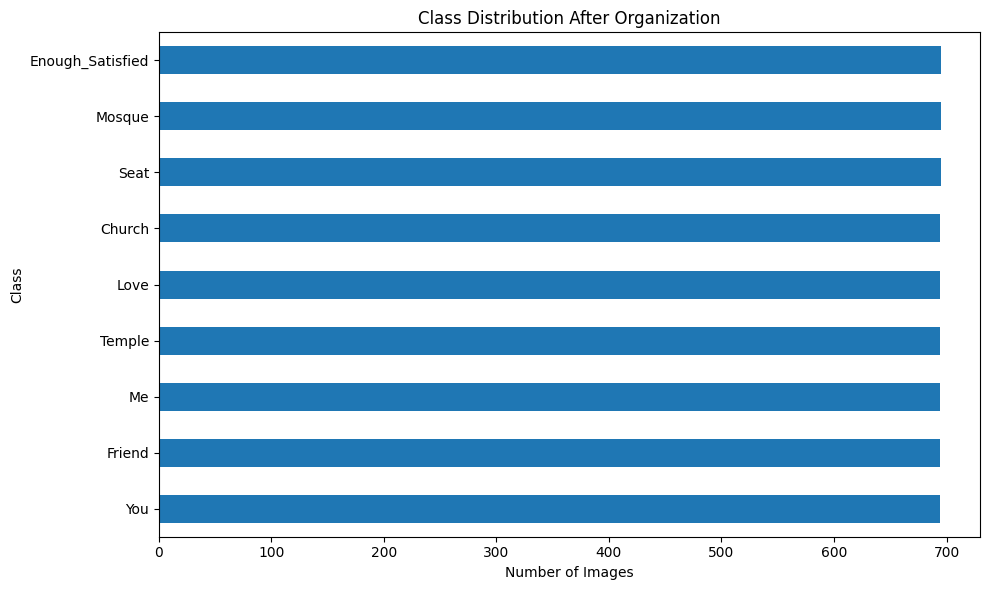

Found 6249 files belonging to 9 classes.
Using 5000 files for training.
Found 6249 files belonging to 9 classes.
Using 1249 files for validation.


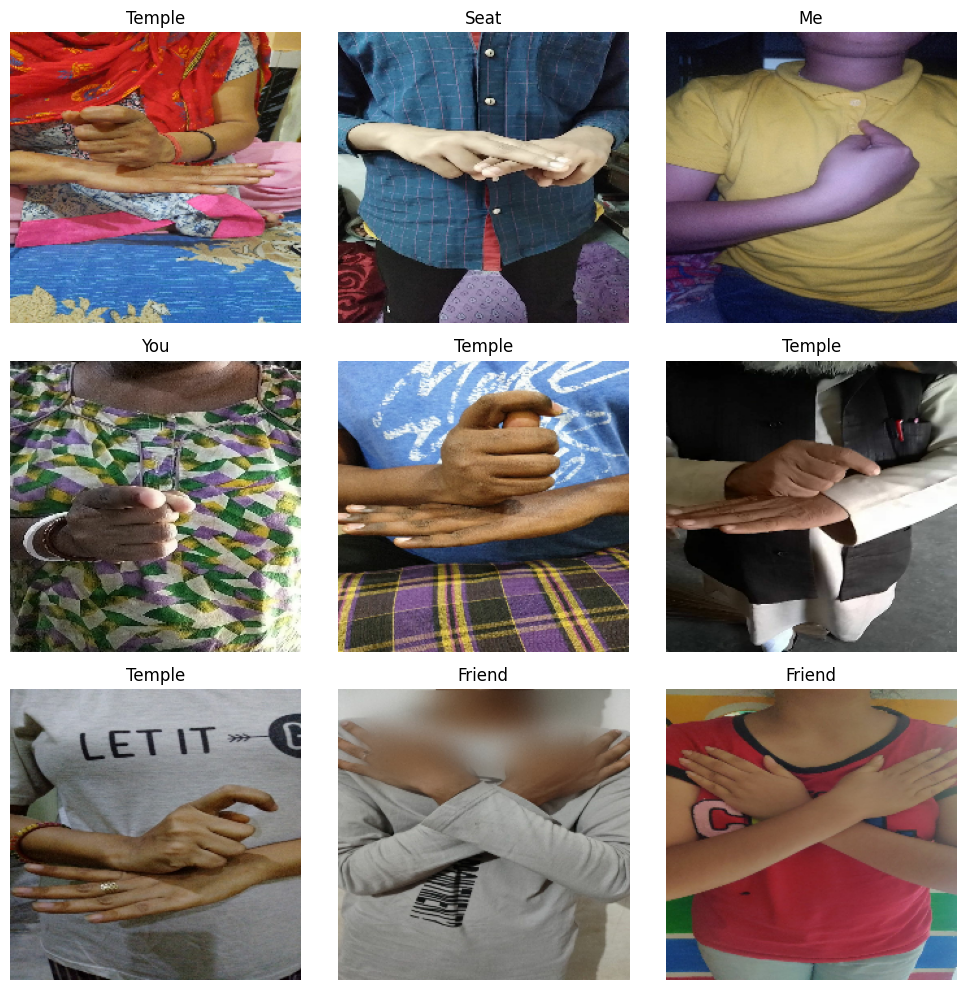

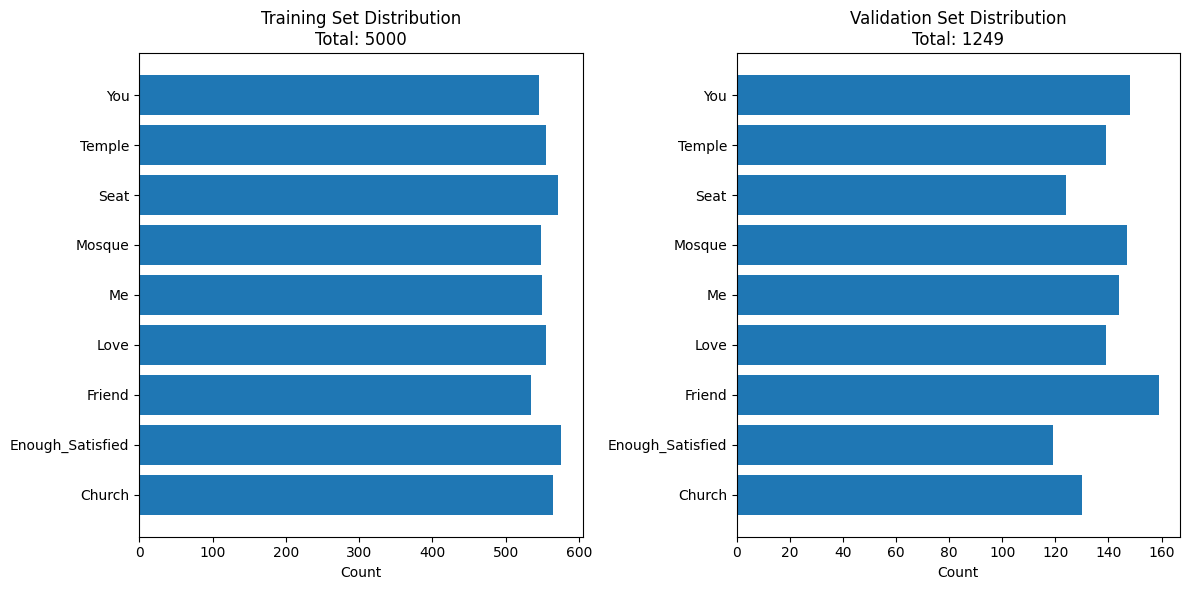

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocess_input                     │ (None, 224, 224, 3)         │               0 │
│ (PreprocessInputLayer)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,773,513 (94.50 MB)

 Trainable params: 1,184,265 (4.52 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1710 - loss: 3.2772
Epoch 1: val_accuracy improved from -inf to 0.27782, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 185ms/step - accuracy: 0.1712 - loss: 3.2754 - val_accuracy: 0.2778 - val_loss: 2.2596 - learning_rate: 0.0010
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2438 - loss: 2.4010
Epoch 2: val_accuracy improved from 0.27782 to 0.38191, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 171ms/step - accuracy: 0.2439 - loss: 2.4005 - val_accuracy: 0.3819 - val_loss: 1.7113 - learning_rate: 0.0010
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2926 - loss: 2.1262
Epoch 3: val_accuracy improved from 0.38191 to 0.42834, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.2926 - loss: 2.1258 - val_accuracy: 0.4283 - val_loss: 1.5558 - learning_rate: 0.0010
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 

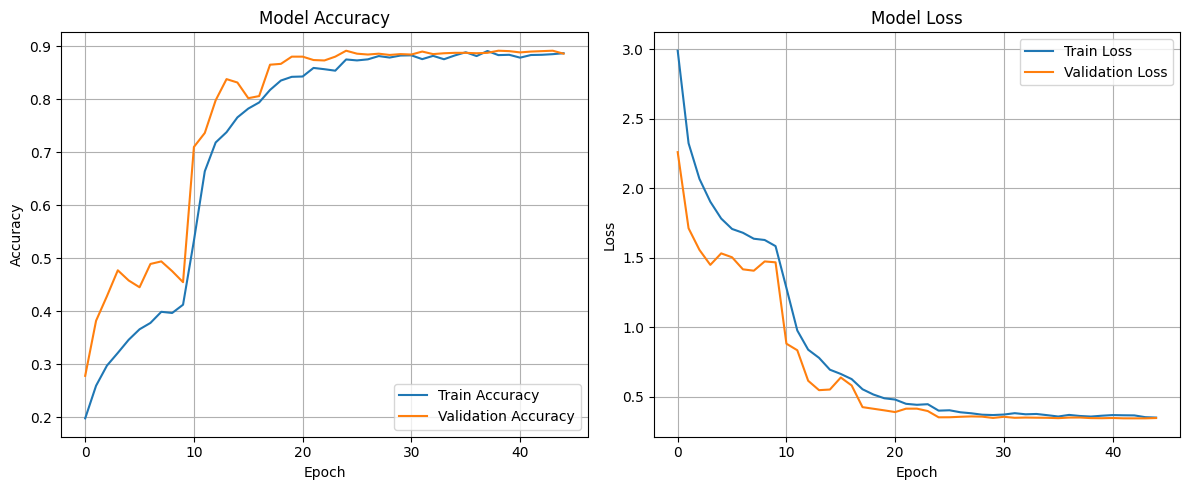

<Figure size 1000x1000 with 0 Axes>

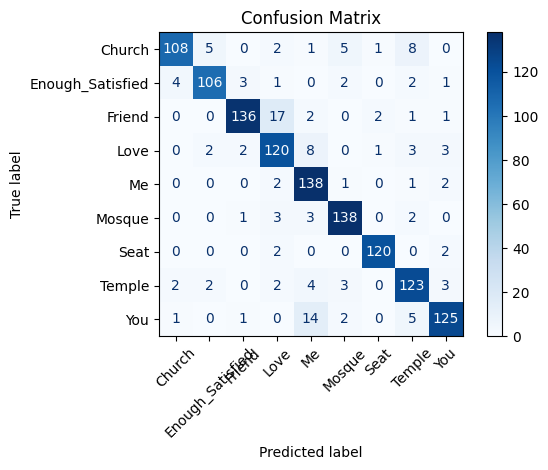

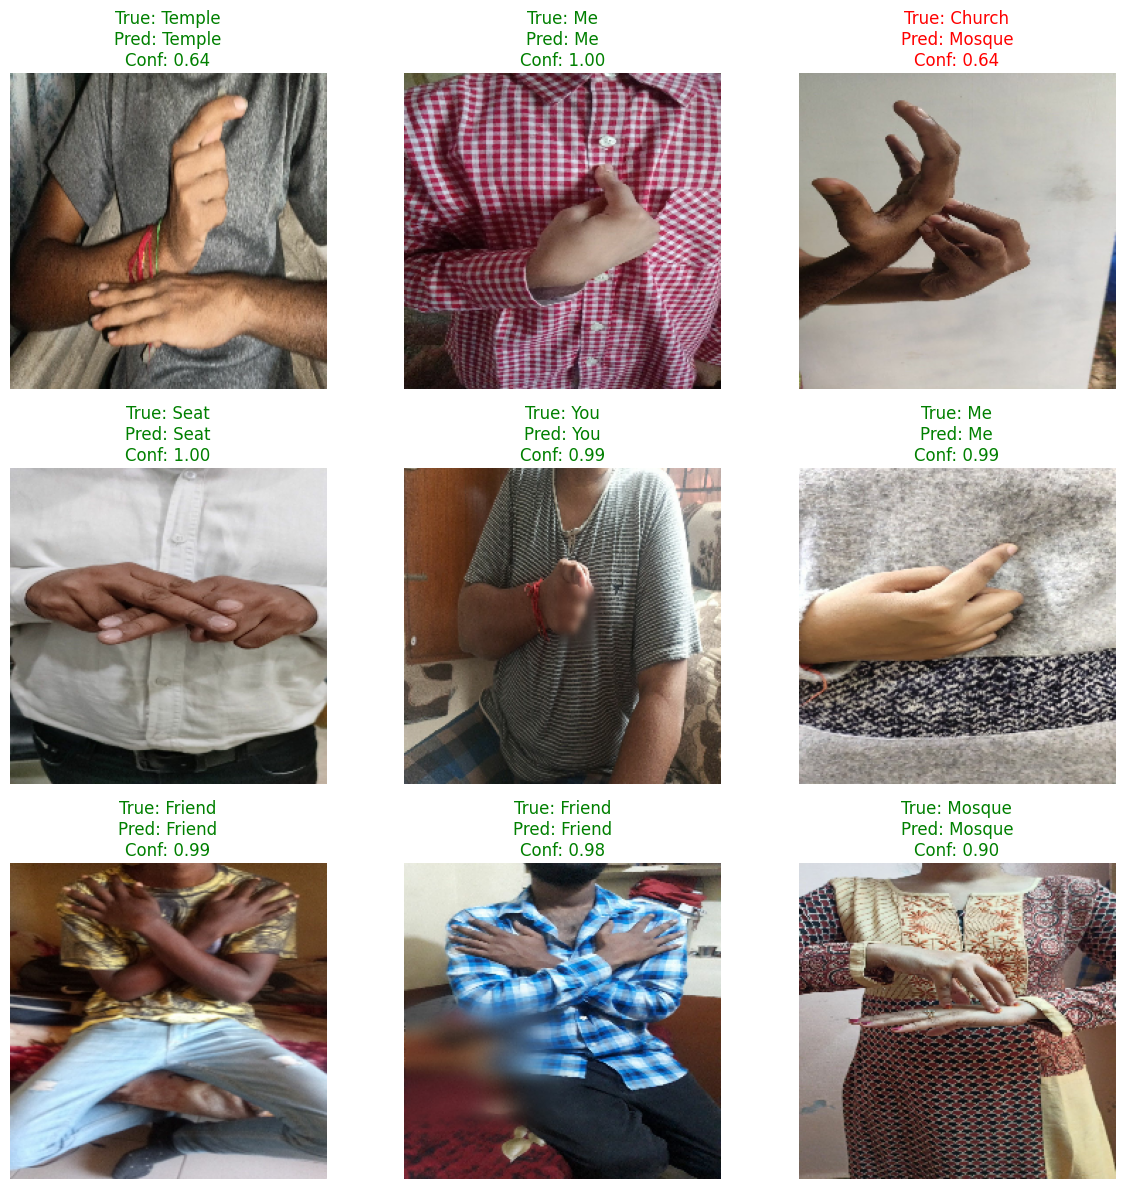

In [ ]:
# Step 3: Custom Preprocessing Layer
class PreprocessInputLayer(layers.Layer):
    def __init__(self, name="preprocess_input", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs):
        return preprocess_input(inputs)

    def get_config(self):
        return super().get_config()

# Step 4: Create Enhanced Transfer Learning Model
def create_transfer_learning_model(img_size=(224, 224, 3), num_classes=9):
    logging.info("Creating transfer learning model with ResNet50...")
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size)
    base_model.trainable = False

    model = models.Sequential([
        layers.Input(shape=img_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.4),  # Increased
        layers.RandomZoom(0.4),      # Increased
        layers.RandomContrast(0.4),  # Increased
        layers.RandomBrightness(0.4),# Increased
        layers.RandomTranslation(0.3, 0.3),  # Increased
        layers.RandomContrast(0.2),  # Added for more variability
        PreprocessInputLayer(),
        #layers.Lambda(preprocess_input),


        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  # Increased to 0.6
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  # Increased to 0.6
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Step 5: Train Model
def train_model(model, train_ds, val_ds, class_weights, epochs_initial=10, epochs_fine_tune=50):
    logging.info("Training model...")
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    early_stopping_initial = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True, verbose=1)
    early_stopping_fine_tune = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True, verbose=1)  # Increased patience
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)  # Adjusted factor

    base_model_layer = next(layer for layer in model.layers if isinstance(layer, tf.keras.Model))
    logging.info(f"Base model: {base_model_layer.__class__.__name__} '{base_model_layer.name}'")

    # Phase 1: Initial training
    base_model_layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history1 = model.fit(train_ds, validation_data=val_ds, epochs=epochs_initial, callbacks=[early_stopping_initial, checkpoint, lr_scheduler],
                         class_weight=class_weights)

    # Phase 2: Fine-tuning
    base_model_layer.trainable = True
    for layer in base_model_layer.layers[:-75]:  # Unfreeze more layers
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history2 = model.fit(train_ds, validation_data=val_ds, epochs=epochs_fine_tune, callbacks=[early_stopping_fine_tune, checkpoint, lr_scheduler],
                         class_weight=class_weights)

    history = {key: history1.history[key] + history2.history[key] for key in history1.history}
    return history

# Step 6: Evaluate and Visualize
def evaluate_and_visualize(history, val_ds, class_names):
    best_model = models.load_model('best_model.keras', custom_objects={'PreprocessInputLayer': PreprocessInputLayer, 'preprocess_input': preprocess_input})
    logging.info("Evaluating best model on validation set...")
    val_loss, val_acc = best_model.evaluate(val_ds)
    logging.info(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    y_true, y_pred = [], []
    for images, labels in val_ds:
        predictions = best_model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    visualize_predictions(best_model, val_ds, class_names)

# Step 7: Visualize Predictions
def visualize_predictions(model, dataset, class_names, num_images=9):
    images, labels = next(iter(dataset))
    predictions = model.predict(images, verbose=0)
    pred_probs = np.max(predictions, axis=1)
    pred_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        color = 'green' if pred_labels[i] == labels[i] else 'red'
        title = f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}\nConf: {pred_probs[i]:.2f}"
        plt.title(title, color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Step 8: Main Execution
def main():
    data_dir = '/content/drive/MyDrive/sign_language_data'
    image_dir = '/content/images'
    valid_classes = ['Church', 'Enough/Satisfied', 'Friend', 'Love', 'Me', 'Mosque', 'Seat', 'Temple', 'You']
    safe_valid_classes = [class_name.replace('/', '_') for class_name in valid_classes]

    train_df = pd.read_csv(os.path.join(data_dir, 'Train.csv'))
    test_df = pd.read_csv(os.path.join(data_dir, 'Test.csv'))
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    class_distribution = organize_images(combined_df, image_dir)
    labels = [safe_valid_classes.index(row['Label'].replace('/', '_'))
              for _, row in combined_df.iterrows() if row['Label'] in valid_classes]
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = dict(enumerate(class_weights))
    logging.info("Class Weights:")
    logging.info(class_weights_dict)

    train_ds, val_ds, class_names = load_and_visualize_dataset(image_dir, safe_valid_classes)
    model = create_transfer_learning_model(img_size=(224, 224, 3), num_classes=len(class_names))

    for i, layer in enumerate(model.layers):
        logging.info(f"Layer {i}: {layer.__class__.__name__} - {layer.name}")

    history = train_model(model, train_ds, val_ds, class_weights_dict)
    evaluate_and_visualize(history, val_ds, class_names)

    logging.info("Best model saved as 'best_model.keras'")

if __name__ == "__main__":
    main()

In [ ]:
# creating the destiantion direcotry
os.makedirs('/content/drive/MyDrive/sign_language_models/', exist_ok=True)


# loading the best model
best_model = models.load_model('best_model.keras',
                               custom_objects={ 'PreprocessInputLayer': PreprocessInputLayer})

# Save it to your desired location
best_model.save('/content/drive/MyDrive/sign_language_models/best_model.keras')
print("Model successfully saved to Google Drive")


Model successfully saved to Google Drive


TypeError: cannot pickle 'module' object